## Biomechanical features of orthopedic patients

In [2]:
# load libraries

import numpy as np
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import matplotlib.pyplot as plt
import sklearn
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

C:\Users\felix\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
# load data

data = pd.read_csv(r"C:\Users\felix\OneDrive\Dokumente\Python Projects\BioMed Case\column_2C_weka.csv", sep=",")

data.head(10)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,Abnormal
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,Abnormal
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,Abnormal
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,Abnormal
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,Abnormal


In [18]:
# replace normal and abnormal by binary values
 
for index, row in data.iterrows():
    if row['class'] == 'Normal':
        data.at[index, 'class'] = 1
    else:
        data.at[index, 'class'] = 0

data.head(10)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,0
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,0
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,0
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,0
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,0


In [19]:
data.groupby('class')['class'].count()

class
0    210
1    100
Name: class, dtype: int64

Split data into training/test sets -> but first check propensities and make sure they stay the same for each split

In [20]:
random.seed(1234)
train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

print('training set:', len(train), 
      '\nvalidation set:', len(validate),
      '\ntest set:', len(test))

training set: 186 
validation set: 62 
test set: 62


In [21]:
train.groupby('class')['class'].count()

class
0    129
1     57
Name: class, dtype: int64

In [9]:
validate.groupby('class')['class'].count()

class
Abnormal    41
Normal      21
Name: class, dtype: int64

In [10]:
test.groupby('class')['class'].count()

class
Abnormal    38
Normal      24
Name: class, dtype: int64

no class imbalances - in each set, there are approximately equal class distribution (2:1)

In [11]:
train.dtypes

pelvic_incidence            float64
pelvic_tilt numeric         float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                        object
dtype: object

In [12]:
# check for missing values

null_value_rows = train.iloc[:, 0:6].isna().any()

null_value_rows

pelvic_incidence            False
pelvic_tilt numeric         False
lumbar_lordosis_angle       False
sacral_slope                False
pelvic_radius               False
degree_spondylolisthesis    False
dtype: bool

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, 32 to 0
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          186 non-null    float64
 1   pelvic_tilt numeric       186 non-null    float64
 2   lumbar_lordosis_angle     186 non-null    float64
 3   sacral_slope              186 non-null    float64
 4   pelvic_radius             186 non-null    float64
 5   degree_spondylolisthesis  186 non-null    float64
 6   class                     186 non-null    object 
dtypes: float64(6), object(1)
memory usage: 11.6+ KB


In [14]:

train.describe(percentiles=[.25,.50,.75])

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,61.788955,18.201559,53.012418,43.587396,117.930706,30.537058
std,18.510883,10.356266,18.810164,14.435195,14.395899,43.077348
min,26.147921,-6.554948,14.000000,13.516568,70.082575,-10.675871
25%,46.403215,10.705426,38.250000,33.347122,110.693560,2.012601
50%,61.018977,16.694499,50.633985,42.678047,118.559498,20.711718
75%,75.402931,23.061862,65.154209,52.883139,125.643056,52.418760
max,129.834041,49.431864,100.744220,121.429566,163.071041,418.543082


Outlier analysis 

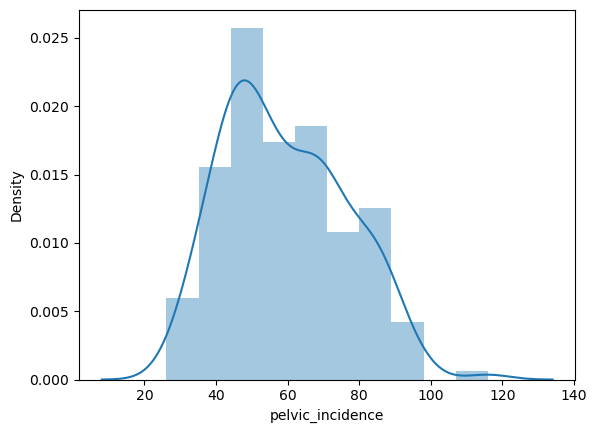

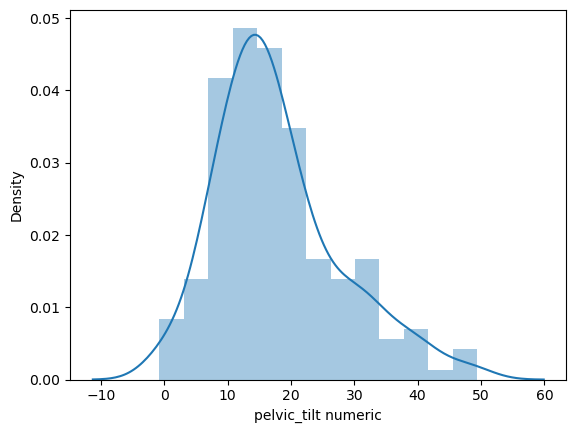

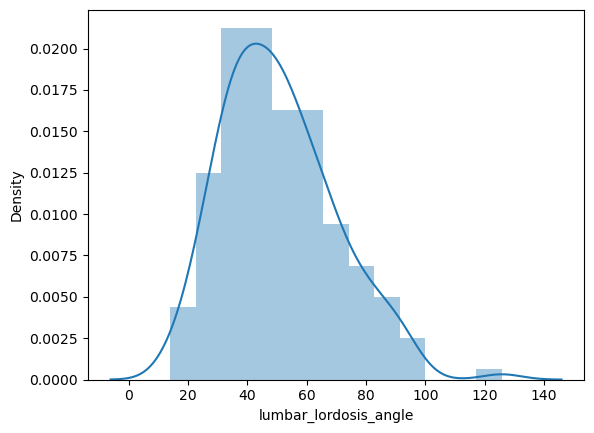

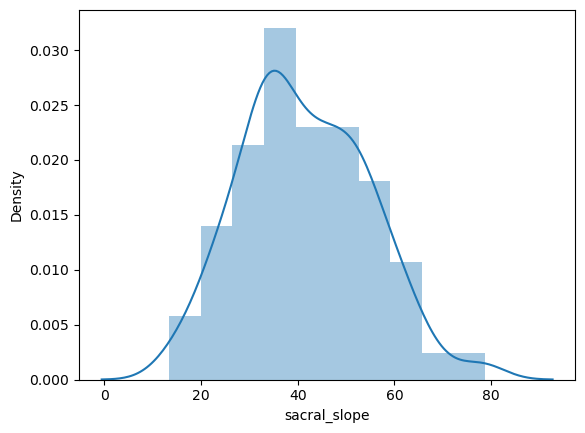

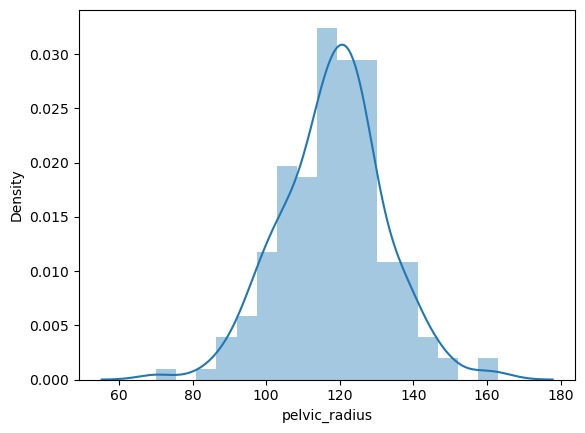

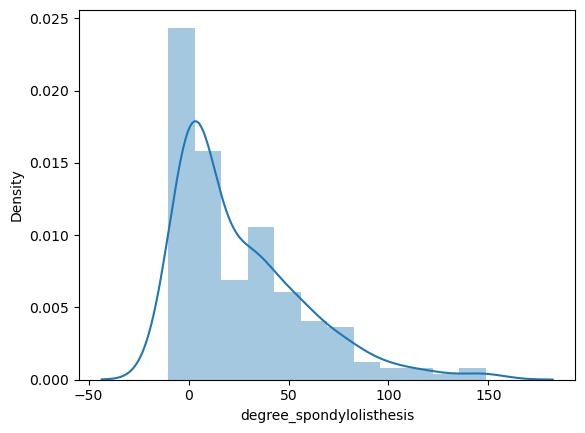

In [22]:
for i, col in enumerate(train.columns[0:6]):
    plt.figure(i)
    sns.distplot(train[col])

[Text(0.5, 0, 'pelvic_incidence'),
 Text(1.5, 0, 'pelvic_tilt numeric'),
 Text(2.5, 0, 'lumbar_lordosis_angle'),
 Text(3.5, 0, 'sacral_slope'),
 Text(4.5, 0, 'pelvic_radius'),
 Text(5.5, 0, 'degree_spondylolisthesis'),
 Text(6.5, 0, 'class')]

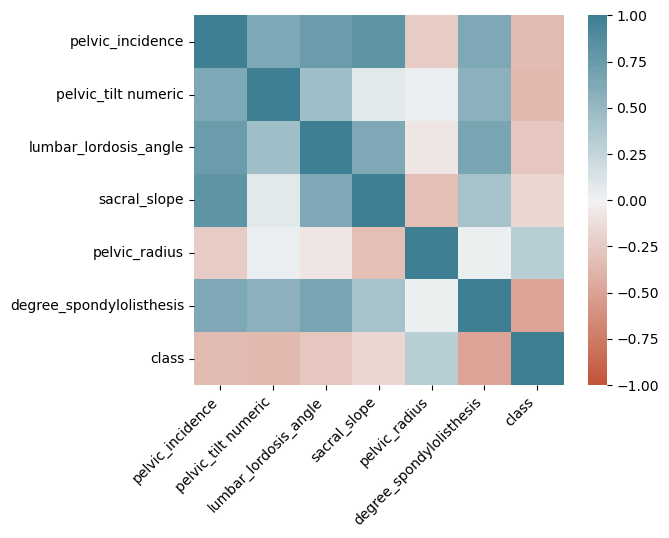

In [23]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [24]:
x_train = train.drop(['class'], axis = 1)
x_validate = validate.drop(['class'], axis = 1)
x_test = test.drop(['class'], axis = 1)

y_train = train['class']
y_validate = validate['class']
y_test = test['class']

In [25]:
# Concatenate the training and validation sets for cross-validation
x_train_validate = pd.concat([x_train, x_validate])
y_train_validate = pd.concat([y_train, y_validate])

# make sure dependent variable is in integer dtype
y_train_validate = y_train_validate.astype(int)
y_test = y_test.astype(int)

# normalize independent variables as preprocessing step
x_train_validate = preprocessing.normalize(x_train_validate)
x_test = preprocessing.normalize(x_test)

Modeling: KNN

In [34]:
seed = 1234
np.random.seed(seed)
knn_model = KNeighborsClassifier()

# set up a tuning grid
param_grid = {'n_neighbors': range(1, 21)}

# metric
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, greater_is_better=True)
}


# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scoring, refit='accuracy')
grid_search.fit(x_train_validate, y_train_validate)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)}, refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [35]:
# Print the best k, accuracy, and ROC AUC
print("Best k:", grid_search.best_params_['n_neighbors'])
print("Best Accuracy:", grid_search.best_score_)
print("Best ROC AUC:", grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])

Best k: 2
Best Accuracy: 0.8306122448979592
Best ROC AUC: 0.7643382352941177


In [28]:
best_k = grid_search.best_params_['n_neighbors']
final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
final_knn_model.fit(x_train_validate, y_train_validate)

KNeighborsClassifier(n_neighbors=2)

In [36]:
# Evaluate the final model on the test set
knn_y_pred_test = final_knn_model.predict(x_test)
knn_accuracy_test = accuracy_score(y_test, knn_y_pred_test)
knn_roc_auc_test = roc_auc_score(y_test, knn_y_pred_test)

print("Accuracy on Test Set:", knn_accuracy_test)
print("ROC AUC on Test Set:", knn_roc_auc_test)

Accuracy on Test Set: 0.7580645161290323
ROC AUC on Test Set: 0.6795454545454546


In [30]:
# Confusion Matrix
knn_conf_mat = confusion_matrix(y_test, knn_y_pred_test)
print("Confusion Matrix:\n", knn_conf_mat)

Confusion Matrix:
 [[38  2]
 [13  9]]


In [31]:
# Calculate Sensitivity and Specificity
knn_tn, knn_fp, knn_fn, knn_tp = knn_conf_mat.ravel()

knn_sensitivity = knn_tp / (knn_tp + knn_fn)
knn_specificity = knn_tn / (knn_tn + knn_fp)

print(f"Sensitivity (True Positive Rate): {knn_sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {knn_specificity:.4f}")

Sensitivity (True Positive Rate): 0.4091
Specificity (True Negative Rate): 0.9500


Modeling: Lasso

In [42]:
seed = 1234
np.random.seed(seed)

lasso_model = LogisticRegression(penalty='l1', solver='liblinear')

lasso_param_grid = {'C': np.logspace(-3, 3, 100)}

lasso_grid_search = GridSearchCV(lasso_model, lasso_param_grid, cv=5, scoring='accuracy')  
lasso_grid_search.fit(x_train_validate, y_train_validate)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             scoring='accuracy')

In [43]:
# Print the best hyperparameter
best_C = lasso_grid_search.best_params_['C']
print("Best C:", best_C)

Best C: 123.28467394420659


In [44]:
# Train the final Lasso model with the best hyperparameter on the entire training set
best_lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, random_state=seed)
best_lasso_model.fit(x_train_validate, y_train_validate)

LogisticRegression(C=123.28467394420659, penalty='l1', random_state=1234,
                   solver='liblinear')

In [45]:
# Evaluate the final Lasso model on the test set
lasso_y_pred_test = best_lasso_model.predict(x_test)

lasso_accuracy_test = accuracy_score(y_test, lasso_y_pred_test)
lasso_roc_auc_test = roc_auc_score(y_test, lasso_y_pred_test)

print("Accuracy on Test Set:", lasso_accuracy_test)
print("ROC AUC on Test Set:", lasso_roc_auc_test)

Accuracy on Test Set: 0.7903225806451613
ROC AUC on Test Set: 0.7659090909090909


In [46]:
# Confusion Matrix
lasso_conf_mat = confusion_matrix(y_test, lasso_y_pred_test)
print("Confusion Matrix:\n", lasso_conf_mat)

# Calculate Sensitivity and Specificity
lasso_tn, lasso_fp, lasso_fn, lasso_tp = lasso_conf_mat.ravel()

lasso_sensitivity = lasso_tp / (lasso_tp + lasso_fn)
lasso_specificity = lasso_tn / (lasso_tn + lasso_fp)

print(f"Sensitivity (True Positive Rate): {lasso_sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {lasso_specificity:.4f}")

Confusion Matrix:
 [[34  6]
 [ 7 15]]
Sensitivity (True Positive Rate): 0.6818
Specificity (True Negative Rate): 0.8500


Modeling: Random Forest

In [55]:
seed = 1234

rf_model = RandomForestClassifier(random_state=seed)

param_grid = {
    'max_features': list(range(1, 6))}

rf_grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')  
rf_grid_search.fit(x_train_validate, y_train_validate)

# Print the best hyperparameter
print("Best max_features (mtry):", rf_grid_search.best_params_['max_features'])

Best max_features (mtry): 2


In [56]:
best_rf_model = RandomForestClassifier(max_features=rf_grid_search.best_params_['max_features'])
best_rf_model.fit(x_train_validate, y_train_validate)

RandomForestClassifier(max_features=2)

In [57]:
rf_y_pred_test = best_rf_model.predict(x_test)

rf_accuracy_test = accuracy_score(y_test, rf_y_pred_test)
rf_roc_auc_test = roc_auc_score(y_test, rf_y_pred_test)

print("Accuracy on Test Set:", rf_accuracy_test)
print("ROC AUC on Test Set:", rf_roc_auc_test)

Accuracy on Test Set: 0.8064516129032258
ROC AUC on Test Set: 0.7579545454545455


In [58]:
# Confusion Matrix
rf_conf_mat = confusion_matrix(y_test, rf_y_pred_test)
print("Confusion Matrix:\n", rf_conf_mat)

# Calculate Sensitivity and Specificity
rf_tn, rf_fp, rf_fn, rf_tp = rf_conf_mat.ravel()

rf_sensitivity = rf_tp / (rf_tp + rf_fn)
rf_specificity = rf_tn / (rf_tn + rf_fp)

print(f"Sensitivity (True Positive Rate): {rf_sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {rf_specificity:.4f}")

Confusion Matrix:
 [[37  3]
 [ 9 13]]
Sensitivity (True Positive Rate): 0.5909
Specificity (True Negative Rate): 0.9250


In [33]:
results_table_combined = 

SyntaxError: invalid syntax (3095306217.py, line 1)